# 02 Temporal Dynamics of AI Incidents

**Goal:** Analyze how incident reporting evolves over time using the strongest available time signals.

This notebook:
- Extracts usable date fields (incident dates + report publication dates)
- Produces reproducible time-series plots
- Documents limitations (e.g., missing incident↔report mapping)

In [10]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA = Path("../data")
OUT = Path("../outputs/figures")
OUT.mkdir(parents=True, exist_ok=True)

inc = pd.read_csv(DATA / "incidents.csv")
rep = pd.read_csv(DATA / "reports.csv")
sub = pd.read_csv(DATA / "submissions.csv")

# normalize columns
inc.columns = [c.strip().lower() for c in inc.columns]
rep.columns = [c.strip().lower() for c in rep.columns]
sub.columns = [c.strip().lower() for c in sub.columns]

print("Incidents:", inc.shape)
print("Reports:", rep.shape)
print("Submissions:", sub.shape)

def parse_date(df, col):
    if col not in df.columns:
        return None
    return pd.to_datetime(df[col], errors="coerce", utc=True).dt.tz_convert(None)

inc_date_candidates = ["incident_date", "date", "incident_datetime", "incident_time"]
rep_date_candidates = ["date_published", "date_submitted", "date_modified", "date_downloaded"]

inc_date_col = None
for c in inc_date_candidates:
    if c in inc.columns:
        s = parse_date(inc, c)
        if s is not None and s.notna().sum() > 0:
            inc_date_col = c
            inc["_incident_dt"] = s
            break

rep_date_col = None
for c in rep_date_candidates:
    if c in rep.columns:
        s = parse_date(rep, c)
        if s is not None and s.notna().sum() > 0:
            rep_date_col = c
            rep["_report_dt"] = s
            break

print("Chosen incident date column:", inc_date_col)
print("Chosen report date column:", rep_date_col)
print("Incidents with usable incident date:", 0 if inc_date_col is None else inc["_incident_dt"].notna().sum())
print("Reports with usable report date:", 0 if rep_date_col is None else rep["_report_dt"].notna().sum())

Incidents: (1367, 9)
Reports: (6687, 21)
Submissions: (45, 15)
Chosen incident date column: date
Chosen report date column: date_published
Incidents with usable incident date: 1367
Reports with usable report date: 6077


In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA = Path("../data")
OUT = Path("../outputs/figures")
OUT.mkdir(parents=True, exist_ok=True)

inc = pd.read_csv(DATA / "incidents.csv")
rep = pd.read_csv(DATA / "reports.csv")
sub = pd.read_csv(DATA / "submissions.csv")

# normalize columns
inc.columns = [c.strip().lower() for c in inc.columns]
rep.columns = [c.strip().lower() for c in rep.columns]
sub.columns = [c.strip().lower() for c in sub.columns]

print("Incidents:", inc.shape)
print("Reports:", rep.shape)
print("Submissions:", sub.shape)

def parse_date(df, col):
    if col not in df.columns:
        return None
    return pd.to_datetime(df[col], errors="coerce", utc=True).dt.tz_convert(None)

inc_date_candidates = ["incident_date", "date", "incident_datetime", "incident_time"]
rep_date_candidates = ["date_published", "date_submitted", "date_modified", "date_downloaded"]

inc_date_col = None
for c in inc_date_candidates:
    if c in inc.columns:
        s = parse_date(inc, c)
        if s is not None and s.notna().sum() > 0:
            inc_date_col = c
            inc["_incident_dt"] = s
            break

rep_date_col = None
for c in rep_date_candidates:
    if c in rep.columns:
        s = parse_date(rep, c)
        if s is not None and s.notna().sum() > 0:
            rep_date_col = c
            rep["_report_dt"] = s
            break

print("Chosen incident date column:", inc_date_col)
print("Chosen report date column:", rep_date_col)
print("Incidents with usable incident date:", 0 if inc_date_col is None else inc["_incident_dt"].notna().sum())
print("Reports with usable report date:", 0 if rep_date_col is None else rep["_report_dt"].notna().sum())

Incidents: (1367, 9)
Reports: (6687, 21)
Submissions: (45, 15)
Chosen incident date column: date
Chosen report date column: date_published
Incidents with usable incident date: 1367
Reports with usable report date: 6077


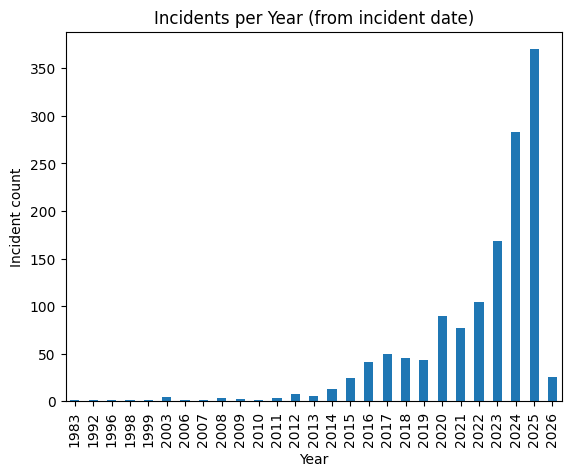

incident_year
2012      8
2013      6
2014     13
2015     24
2016     41
2017     50
2018     45
2019     43
2020     90
2021     77
2022    104
2023    168
2024    283
2025    370
2026     25
dtype: int64

In [12]:
if inc_date_col is None:
    print("No usable incident date column found in incidents.csv")
else:
    inc["incident_year"] = inc["_incident_dt"].dt.year
    yearly_inc = inc.dropna(subset=["incident_year"]).groupby("incident_year").size()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    yearly_inc.plot(kind="bar", ax=ax)
    ax.set_title("Incidents per Year (from incident date)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Incident count")
    fig.savefig(OUT / "10_incidents_per_year.png", bbox_inches="tight", dpi=200)
    plt.show()

    display(yearly_inc.tail(15))

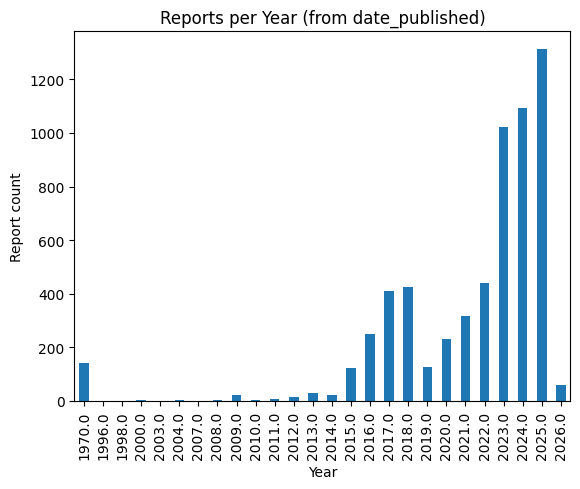

report_year
2012.0      15
2013.0      32
2014.0      22
2015.0     125
2016.0     251
2017.0     412
2018.0     427
2019.0     126
2020.0     230
2021.0     316
2022.0     442
2023.0    1023
2024.0    1092
2025.0    1313
2026.0      60
dtype: int64

In [13]:
if rep_date_col is None:
    print("No usable report date column found in reports.csv")
else:
    rep["report_year"] = rep["_report_dt"].dt.year
    yearly_rep = rep.dropna(subset=["report_year"]).groupby("report_year").size()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    yearly_rep.plot(kind="bar", ax=ax)
    ax.set_title(f"Reports per Year (from {rep_date_col})")
    ax.set_xlabel("Year")
    ax.set_ylabel("Report count")
    fig.savefig(OUT / "11_reports_per_year.png", bbox_inches="tight", dpi=200)
    plt.show()

    display(yearly_rep.tail(15))

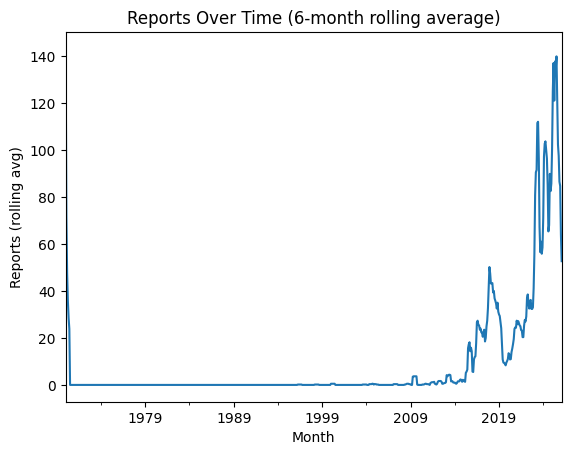

_report_dt
2024-03-31     60
2024-04-30     74
2024-05-31     89
2024-06-30     75
2024-07-31     44
2024-08-31     50
2024-09-30     76
2024-10-31    205
2024-11-30     45
2024-12-31     94
2025-01-31    133
2025-02-28    197
2025-03-31    148
2025-04-30    109
2025-05-31    145
2025-06-30     73
2025-07-31    167
2025-08-31     85
2025-09-30     35
2025-10-31     80
2025-11-30     79
2025-12-31     62
2026-01-31     43
2026-02-28     17
Freq: ME, dtype: int64

In [14]:
if rep_date_col is not None:
    monthly = rep.dropna(subset=["_report_dt"]).set_index("_report_dt").resample("ME").size()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    monthly.rolling(6, min_periods=1).mean().plot(ax=ax)
    ax.set_title("Reports Over Time (6-month rolling average)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Reports (rolling avg)")
    fig.savefig(OUT / "12_reports_monthly_rolling.png", bbox_inches="tight", dpi=200)
    plt.show()

    display(monthly.tail(24))

Lag proxy using report date column: date_published_rep
Lag sample size (URL-merged subset): 0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64


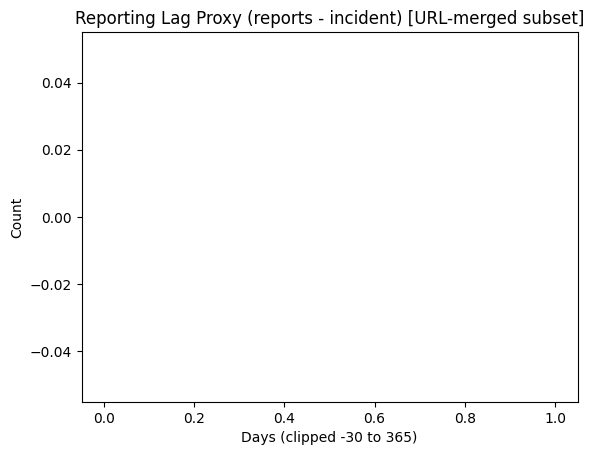

In [15]:
import numpy as np

# Lag proxy using URL-merged subset (small, but reproducible)
if "url" in sub.columns and "url" in rep.columns:
    merged = sub.merge(rep, on="url", how="inner", suffixes=("_sub", "_rep"))

    # incident date from submissions
    merged["_incident_dt"] = pd.to_datetime(merged.get("incident_date"), errors="coerce", utc=True).dt.tz_convert(None)

    # choose best report date column from merged data
    report_date_candidates = [
        "date_published_rep", "date_published",
        "date_submitted_rep", "date_submitted",
        "date_modified_rep", "date_modified",
        "date_downloaded_rep", "date_downloaded",
    ]
    rep_date_col2 = next((c for c in report_date_candidates if c in merged.columns), None)
    print("Lag proxy using report date column:", rep_date_col2)

    if rep_date_col2 is None:
        print("No usable report date column found after merge. Date-like columns:",
              [c for c in merged.columns if "date" in c])
    else:
        merged["_published_dt"] = pd.to_datetime(merged[rep_date_col2], errors="coerce", utc=True).dt.tz_convert(None)
        lag_days = (merged["_published_dt"] - merged["_incident_dt"]).dt.days.dropna()

        print("Lag sample size (URL-merged subset):", len(lag_days))
        print(lag_days.describe())

        fig = plt.figure()
        ax = fig.add_subplot(111)
        lag_days.clip(lower=-30, upper=365).plot(kind="hist", bins=40, ax=ax)
        ax.set_title("Reporting Lag Proxy (reports - incident) [URL-merged subset]")
        ax.set_xlabel("Days (clipped -30 to 365)")
        ax.set_ylabel("Count")
        fig.savefig(OUT / "13_reporting_lag_proxy_hist.png", bbox_inches="tight", dpi=200)
        plt.show()
else:
    print("Missing url column in submissions or reports; cannot compute lag proxy.")

## Interpretation & Limitations

- Incident counts reflect documented incidents, not the true underlying rate of harms.
- Report counts reflect both real-world prevalence and changes in media attention / database coverage.
- The lag chart is a **proxy** computed on a small URL-merged subset (submissions ↔ reports), not the full database.